# Test-Time Adaptation for Image Classification (Deep Learning Project)


## Download Datasets

In [ ]:
# download datasets from a shared folder in google drive

!gdown 1-m3lAmp63chP_9kFZjAd5iNTCsck6yA1 # id for imagenet-a
!gdown 1wbmp6PsLiECc4lrKdut1bB2avTKcFPhd # id for imagenet-v2
!gdown 1YFJoAIu0gtABk_BhQrJlmVwR5z8-ABeE # id for imagenet.csv
!gdown 16VtkeeOkgSKbZt7_tQ1VY9AH90g_R-6H # id for imagenetv2-b-33-v2.json


# unzip them!
!tar -xf imagenet-a.tar
!tar -xf imagenetv2-matched-frequency.tar.gz

!ls

Downloading...
From (original): https://drive.google.com/uc?id=1-m3lAmp63chP_9kFZjAd5iNTCsck6yA1
From (redirected): https://drive.google.com/uc?id=1-m3lAmp63chP_9kFZjAd5iNTCsck6yA1&confirm=t&uuid=a5f1f9cb-6b06-465d-a1e3-c030debbce48
To: /content/imagenet-a.tar
100% 688M/688M [00:25<00:00, 27.1MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1wbmp6PsLiECc4lrKdut1bB2avTKcFPhd
From (redirected): https://drive.google.com/uc?id=1wbmp6PsLiECc4lrKdut1bB2avTKcFPhd&confirm=t&uuid=8606aaa9-0af7-4da5-98cb-923fd3738a23
To: /content/imagenetv2-matched-frequency.tar.gz
100% 1.26G/1.26G [00:10<00:00, 115MB/s]
Downloading...
From: https://drive.google.com/uc?id=1YFJoAIu0gtABk_BhQrJlmVwR5z8-ABeE
To: /content/imagenet.csv
100% 21.5k/21.5k [00:00<00:00, 37.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=16VtkeeOkgSKbZt7_tQ1VY9AH90g_R-6H
To: /content/imagenetv2-b-33-v2.json
100% 810k/810k [00:00<00:00, 120MB/s]
imagenet-a	imagenet.csv		 imagenetv2-matched-frequency-format-va

## Import Needed Libraries

In [ ]:
# import libraries
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from PIL import Image
import skimage
import torch
from tqdm import tqdm
import json
import csv
from pathlib import Path

%matplotlib inline
%config InlineBackend.figure_format = "retina"

## Check Device

In [ ]:
# get cuda device
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"
print(f"Using {device} device")

Using cuda device


# Retrieve label names from ImageNet-v2

In [ ]:
def imagenet_v2_mapping():
  """
  Initialize dictionaries for ImageNet and ImageNet-v2 mapping.
  """
  imagenet_v2_dict = {}
  image_net_map_dict = {}

  # Open the JSON file containing ImageNet-v2 mapping
  with open('/content/imagenetv2-b-33-v2.json', 'r') as file:
      json_content = file.read()

  # Open the CSV file containing ImageNet mapping
  with open('/content/imagenet.csv', 'r', encoding='utf-8-sig') as file:
      csv_reader = csv.reader(file, delimiter=';')
       # Populate ImageNet mapping dictionary
      for row in csv_reader:
          key, value = row
          image_net_map_dict[key] = value

  # Extract each element of ImageNet-v2 mapping
  dictonary_array = json.loads(json_content)["image_filenames"]

  # Fill ImageNet-v2 mapping dictionary with its original key-value pairs
  for item in dictonary_array:
      key, value = item
      imagenet_v2_dict[key] = value

  # Assign to ImageNet-v2 mapping the labels' names using ImageNet mapping
  for key, value in imagenet_v2_dict.items():
      new_val = image_net_map_dict[value]
      imagenet_v2_dict[key] = new_val

  return imagenet_v2_dict



In [ ]:
#print(list((imagenet_v2_mapping()).values()))
imagenetv2_classes = list((imagenet_v2_mapping()).values()) # list of imagenet V2 classes

# Retrieve label names from ImageNet-a

In [ ]:
# label map for imagenet-a
label_map = {
    0: "stingray", 1: "goldfinch", 2: "junco", 3: "American robin", 4: "jay", 5: "bald eagle", 6: "vulture", 7: "newt", 8: "American bullfrog", 9: "box turtle", 10: "green iguana",
    11: "agama", 12: "chameleon", 13: "American alligator", 14: "garter snake", 15: "harvestman", 16: "scorpion", 17: "tarantula", 18: "centipede", 19: "sulphur-crested cockatoo",
    20: "lorikeet", 21: "hummingbird", 22: "toucan", 23: "duck", 24: "goose", 25: "koala", 26: "jellyfish", 27: "sea anemone", 28: "flatworm", 29: "snail", 30: "crayfish",
    31: "hermit crab", 32: "flamingo", 33: "great egret", 34: "oystercatcher", 35: "pelican", 36: "sea lion", 37: "Chihuahua", 38: "Golden Retriever", 39: "Rottweiler",
    40: "German Shepherd Dog", 41: "pug", 42: "red fox", 43: "Persian cat", 44: "lynx", 45: "lion", 46: "American black bear", 47: "mongoose", 48: "ladybug", 49: "rhinoceros beetle",
    50: "weevil", 51: "fly", 52: "bee", 53: "ant", 54: "grasshopper", 55: "stick insect", 56: "cockroach", 57: "mantis", 58: "leafhopper", 59: "dragonfly", 60: "monarch butterfly",
    61: "small white", 62: "gossamer-winged butterfly", 63: "starfish", 64: "cottontail rabbit", 65: "porcupine", 66: "fox squirrel", 67: "marmot", 68: "bison", 69: "skunk", 70: "armadillo",
    71: "baboon", 72: "white-headed capuchin", 73: "African bush elephant", 74: "pufferfish", 75: "academic gown", 76: "accordion", 77: "acoustic guitar", 78: "airliner", 79: "ambulance",
    80: "apron", 81: "balance beam", 82: "balloon", 83: "banjo", 84: "barn", 85: "wheelbarrow", 86: "basketball", 87: "lighthouse", 88: "beaker", 89: "bikini", 90: "bow", 91: "bow tie",
    92: "breastplate", 93: "broom", 94: "candle", 95: "canoe", 96: "castle", 97: "cello", 98: "chain", 99: "chest", 100: "Christmas stocking", 101: "cowboy boot", 102: "cradle", 103: "rotary dial telephone",
    104: "digital clock", 105: "doormat", 106: "drumstick", 107: "dumbbell", 108: "envelope", 109: "feather boa", 110: "flagpole", 111: "forklift", 112: "fountain", 113: "garbage truck",
    114: "goblet", 115: "go-kart", 116: "golf cart", 117: "grand piano", 118: "hair dryer", 119: "clothes iron", 120: "jack-o'-lantern", 121: "jeep", 122: "kimono", 123: "lighter",
    124: "limousine", 125: "manhole cover", 126: "maraca", 127: "marimba", 128: "mask", 129: "mitten", 130: "mosque", 131: "nail", 132: "obelisk", 133: "ocarina", 134: "organ", 135: "parachute",
    136: "parking meter", 137: "piggy bank", 138: "billiard table", 139: "hockey puck", 140: "quill", 141: "racket", 142: "reel", 143: "revolver", 144: "rocking chair", 145: "rugby ball",
    146: "salt shaker", 147: "sandal", 148: "saxophone", 149: "school bus", 150: "schooner", 151: "sewing machine", 152: "shovel", 153: "sleeping bag", 154: "snowmobile", 155: "snowplow",
    156: "soap dispenser", 157: "spatula", 158: "spider web", 159: "steam locomotive", 160: "stethoscope", 161: "couch", 162: "submarine", 163: "sundial", 164: "suspension bridge", 165: "syringe",
    166: "tank", 167: "teddy bear", 168: "toaster", 169: "torch", 170: "tricycle", 171: "umbrella", 172: "unicycle", 173: "viaduct", 174: "volleyball", 175: "washing machine", 176: "water tower",
    177: "wine bottle", 178: "shipwreck", 179: "guacamole", 180: "pretzel", 181: "cheeseburger", 182: "hot dog", 183: "broccoli", 184: "cucumber", 185: "bell pepper", 186: "mushroom",
    187: "lemon", 188: "banana", 189: "custard apple", 190: "pomegranate", 191: "carbonara", 192: "bubble", 193: "cliff", 194: "volcano", 195: "baseball player", 196: "rapeseed",
    197: "yellow lady's slipper", 198: "corn", 199: "acorn"
}

# Create the dataloader

In [ ]:
# dataloader
"""
Input arguments:
  batch_size: mini batch size used during training
  img_root: path to the dataset parent folder.
            The folder just above the sub-folders or class folders
"""

def get_data(batch_size, img_root):
  # prepare data transformations for the train loader
  transform = list()
  transform.append(T.Resize((224, 224)))                      # resize each PIL image to 256 x 256
  # transform.append(T.RandomCrop((224, 224)))                  # randomly crop a 224 x 224 patch
  transform.append(T.ToTensor())                              # convert Numpy to Pytorch Tensor
  #####################################################################################################################à
  #transform.append(T.Normalize(mean=[0.485, 0.456, 0.406],
  #                              std=[0.229, 0.224, 0.225]))    # normalize with ImageNet mean
  transform = T.Compose(transform)                            # compose the above transformations into one

  # load data
  dataset = torchvision.datasets.ImageFolder(root=img_root, transform=transform)

  # extract the label mapping for imagentv2
  if img_root == "/content/imagenetv2-matched-frequency-format-val":
      label_map_v2={}
      imagenet_v2_map = imagenet_v2_mapping()
      for file in dataset.imgs:
          # get the image's name
          path = Path(file[0])
          name = path.stem
          # get the numeric value of the label
          label = file[1]
          # Skip if the label is alredy in
          if label in label_map_v2:
              continue
          # assign key-value pair
          label_map_v2[label] = imagenet_v2_map[name]

  # create train and test splits (80/20)
  num_samples = len(dataset)
  training_samples = int(num_samples * 0.8 + 1)
  test_samples = num_samples - training_samples

  training_data, test_data = torch.utils.data.random_split(dataset,
                                                           [training_samples, test_samples])

  # initialize dataloaders
  train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=False)

  if img_root == "/content/imagenetv2-matched-frequency-format-val":
        return train_loader, test_loader, label_map_v2
  else:
        return train_loader, test_loader



In [ ]:
train_loader_imageneta, test_loader_imageneta = get_data(batch_size=1, img_root='/content/imagenet-a')
train_loader_imagenetv2, test_loader_imagenetv2, labels_map = get_data(batch_size=1, img_root='/content/imagenetv2-matched-frequency-format-val')

In [ ]:
print("imagenet-a dataloader: ")
for X, y in test_loader_imageneta:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

print("\nimagenetv2 dataloader: ")
for X, y in test_loader_imagenetv2:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

imagenet-a dataloader: 
Shape of X [N, C, H, W]: torch.Size([1, 3, 224, 224])
Shape of y: torch.Size([1]) torch.int64

imagenetv2 dataloader: 
Shape of X [N, C, H, W]: torch.Size([1, 3, 224, 224])
Shape of y: torch.Size([1]) torch.int64


# Show some images from both Datasets

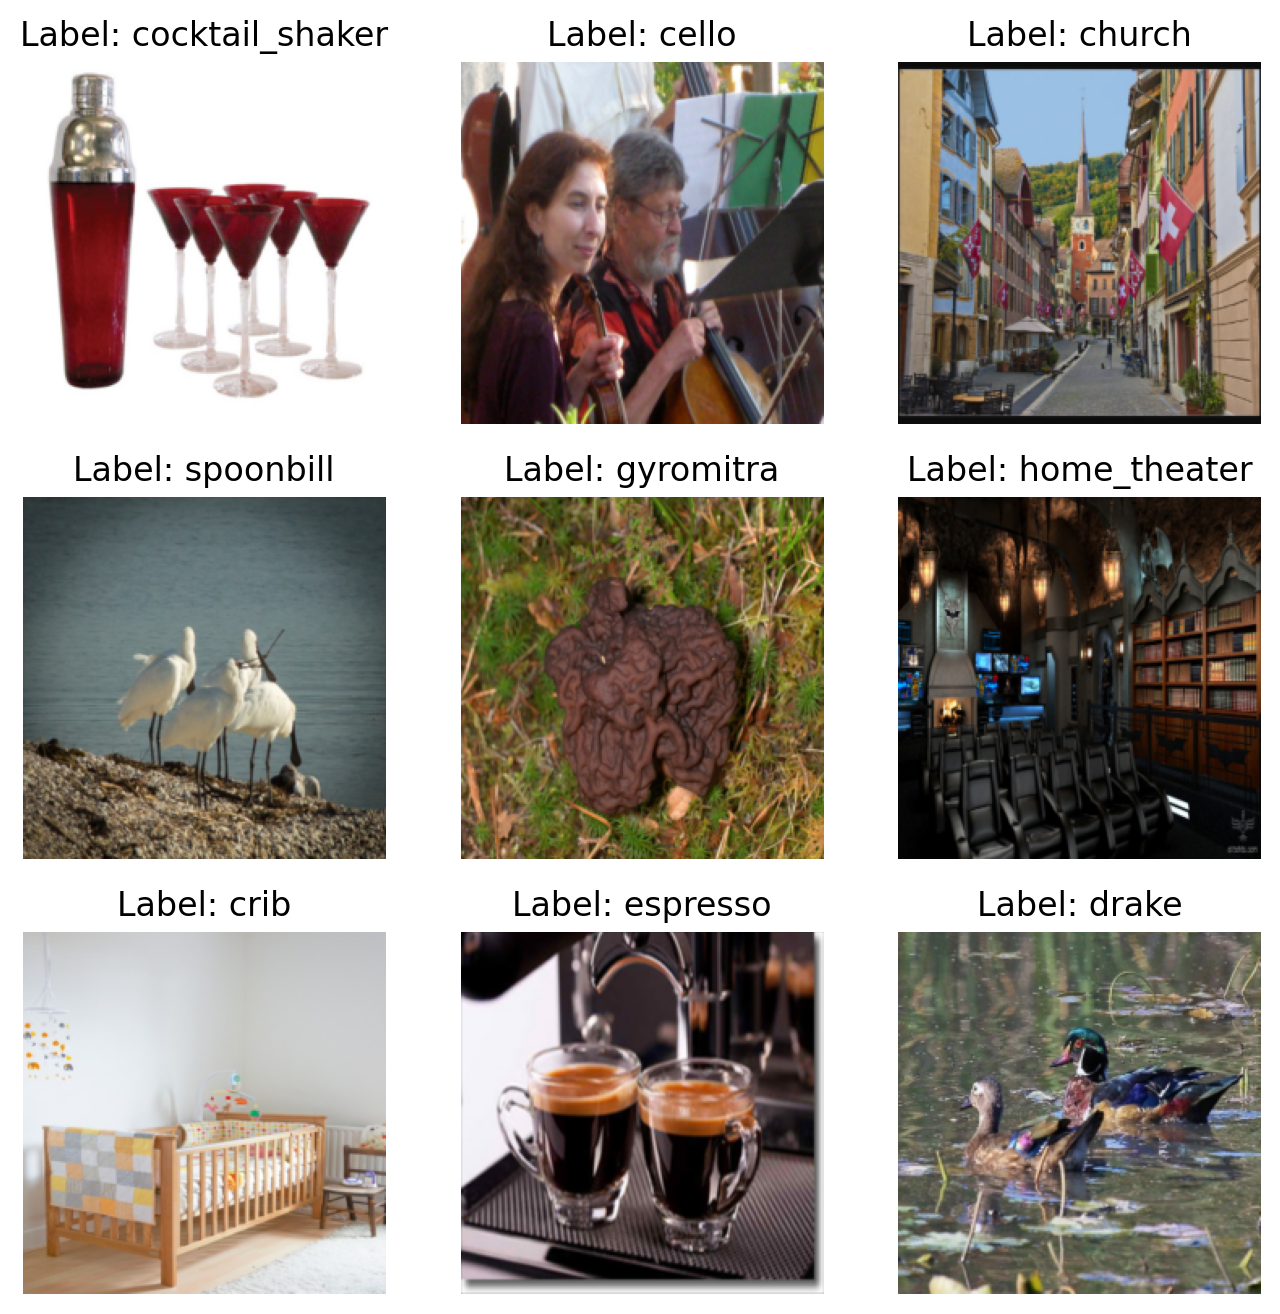

In [ ]:
# show some imagenet-v2 images
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

# Iterate over batches loaded from the DataLoader
for batch_idx, (data, labels) in enumerate(train_loader_imagenetv2, 1):
    # Iterate over data within the batch
    for img_idx, (img, label) in enumerate(zip(data, labels), 1):
        # Add subplot to the figure
        subplot_idx = (batch_idx - 1) * len(data) + img_idx
        if subplot_idx > cols * rows:
            break

        figure.add_subplot(rows, cols, subplot_idx)

        # Display the image and the label
        plt.title(f"Label: {labels_map[label.item()]}")  # Display the label as title
        plt.axis("off")
        plt.imshow(img.permute(1, 2, 0))  # Permute dimensions to fit matplotlib format

    # If enough subplots have been displayed, exit the outer loop
    if batch_idx * len(data) >= cols * rows:
        break

plt.show()


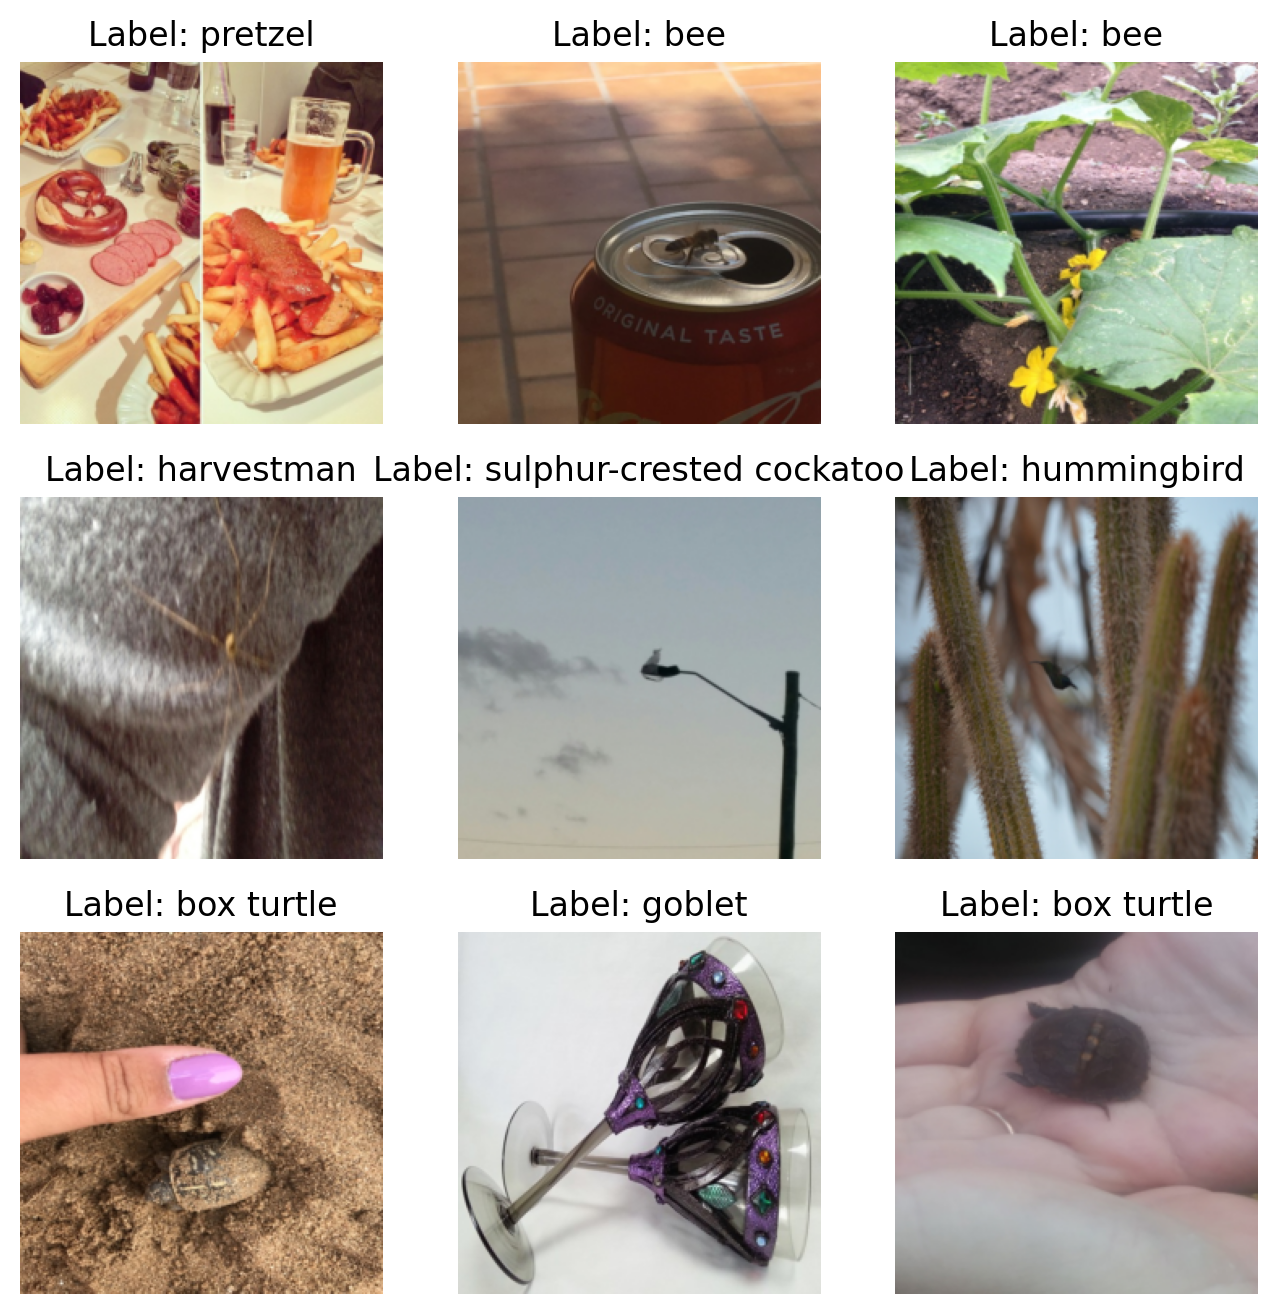

In [ ]:
# show some imagenet-a images

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

# Iterate over batches loaded from the DataLoader
for batch_idx, (data, labels) in enumerate(train_loader_imageneta, 1):
    # Iterate over data within the batch
    for img_idx, (img, label) in enumerate(zip(data, labels), 1):
        # Add subplot to the figure
        subplot_idx = (batch_idx - 1) * len(data) + img_idx
        if subplot_idx > cols * rows:
            break

        figure.add_subplot(rows, cols, subplot_idx)

        # Display the image and the label
        plt.title(f"Label: {label_map[label.item()]}")  # Display the label as title using the label map
        plt.axis("off")
        plt.imshow(img.permute(1, 2, 0))  # Permute dimensions to fit matplotlib format

    # If enough subplots have been displayed, exit the outer loop
    if batch_idx * len(data) >= cols * rows:
        break

plt.show()

## CLIP


In [ ]:
!pip install -q ftfy regex tqdm scikit-learn scikit-image
!pip install -q git+https://github.com/openai/CLIP.git

  Preparing metadata (setup.py) ... done


### Preparing ImageNet labels and prompts

In [ ]:
imageneta_classes = [
    "stingray", "goldfinch", "junco", "American robin", "jay", "bald eagle", "vulture", "newt", "American bullfrog", "box turtle", "green iguana",
    "agama", "chameleon", "American alligator", "garter snake", "harvestman", "scorpion", "tarantula", "centipede", "sulphur-crested cockatoo",
    "lorikeet", "hummingbird", "toucan", "duck", "goose", "koala", "jellyfish", "sea anemone", "flatworm", "snail", "crayfish",
    "hermit crab", "flamingo", "great egret", "oystercatcher", "pelican", "sea lion", "Chihuahua", "Golden Retriever", "Rottweiler",
    "German Shepherd Dog", "pug", "red fox", "Persian cat", "lynx", "lion", "American black bear", "mongoose", "ladybug", "rhinoceros beetle",
    "weevil", "fly", "bee", "ant", "grasshopper", "stick insect", "cockroach", "mantis", "leafhopper", "dragonfly", "monarch butterfly",
    "small white", "gossamer-winged butterfly", "starfish", "cottontail rabbit", "porcupine", "fox squirrel", "marmot", "bison", "skunk", "armadillo",
    "baboon", "white-headed capuchin", "African bush elephant", "pufferfish", "academic gown", "accordion", "acoustic guitar", "airliner", "ambulance",
    "apron", "balance beam", "balloon", "banjo", "barn", "wheelbarrow", "basketball", "lighthouse", "beaker", "bikini", "bow", "bow tie",
    "breastplate", "broom", "candle", "canoe", "castle", "cello", "chain", "chest", "Christmas stocking", "cowboy boot", "cradle", "rotary dial telephone",
    "digital clock", "doormat", "drumstick", "dumbbell", "envelope", "feather boa", "flagpole", "forklift", "fountain", "garbage truck",
    "goblet", "go-kart", "golf cart", "grand piano", "hair dryer", "clothes iron", "jack-o'-lantern", "jeep", "kimono", "lighter",
    "limousine", "manhole cover", "maraca", "marimba", "mask", "mitten", "mosque", "nail", "obelisk", "ocarina", "organ", "parachute",
    "parking meter", "piggy bank", "billiard table", "hockey puck", "quill", "racket", "reel", "revolver", "rocking chair", "rugby ball",
    "salt shaker", "sandal", "saxophone", "school bus", "schooner", "sewing machine", "shovel", "sleeping bag", "snowmobile", "snowplow",
    "soap dispenser", "spatula", "spider web", "steam locomotive", "stethoscope", "couch", "submarine", "sundial", "suspension bridge", "syringe",
    "tank", "teddy bear", "toaster", "torch", "tricycle", "umbrella", "unicycle", "viaduct", "volleyball", "washing machine", "water tower",
    "wine bottle", "shipwreck", "guacamole", "pretzel", "cheeseburger", "hot dog", "broccoli", "cucumber", "bell pepper", "mushroom",
    "lemon", "banana", "custard apple", "pomegranate", "carbonara", "bubble", "cliff", "volcano", "baseball player", "rapeseed",
    "yellow lady's slipper", "corn", "acorn"
]

In [ ]:
imagenet_templates = [
    'a bad photo of a {}.',
    'a photo of many {}.',
    'a sculpture of a {}.',
    'a photo of the hard to see {}.',
    'a low resolution photo of the {}.',
    'a rendering of a {}.',
    'graffiti of a {}.',
    'a bad photo of the {}.',
    'a cropped photo of the {}.',
    'a tattoo of a {}.',
    'the embroidered {}.',
    'a photo of a hard to see {}.',
    'a bright photo of a {}.',
    'a photo of a clean {}.',
    'a photo of a dirty {}.',
    'a dark photo of the {}.',
    'a drawing of a {}.',
    'a photo of my {}.',
    'the plastic {}.',
    'a photo of the cool {}.',
    'a close-up photo of a {}.',
    'a black and white photo of the {}.',
    'a painting of the {}.',
    'a painting of a {}.',
    'a pixelated photo of the {}.',
    'a sculpture of the {}.',
    'a bright photo of the {}.',
    'a cropped photo of a {}.',
    'a plastic {}.',
    'a photo of the dirty {}.',
    'a jpeg corrupted photo of a {}.',
    'a blurry photo of the {}.',
    'a photo of the {}.',
    'a good photo of the {}.',
    'a rendering of the {}.',
    'a {} in a video game.',
    'a photo of one {}.',
    'a doodle of a {}.',
    'a close-up photo of the {}.',
    'a photo of a {}.',
    'the origami {}.',
    'the {} in a video game.',
    'a sketch of a {}.',
    'a doodle of the {}.',
    'a origami {}.',
    'a low resolution photo of a {}.',
    'the toy {}.',
    'a rendition of the {}.',
    'a photo of the clean {}.',
    'a photo of a large {}.',
    'a rendition of a {}.',
    'a photo of a nice {}.',
    'a photo of a weird {}.',
    'a blurry photo of a {}.',
    'a cartoon {}.',
    'art of a {}.',
    'a sketch of the {}.',
    'a embroidered {}.',
    'a pixelated photo of a {}.',
    'itap of the {}.',
    'a jpeg corrupted photo of the {}.',
    'a good photo of a {}.',
    'a plushie {}.',
    'a photo of the nice {}.',
    'a photo of the small {}.',
    'a photo of the weird {}.',
    'the cartoon {}.',
    'art of the {}.',
    'a drawing of the {}.',
    'a photo of the large {}.',
    'a black and white photo of a {}.',
    'the plushie {}.',
    'a dark photo of a {}.',
    'itap of a {}.',
    'graffiti of the {}.',
    'a toy {}.',
    'itap of my {}.',
    'a photo of a cool {}.',
    'a photo of a small {}.',
    'a tattoo of the {}.',
]

print(f"{len(imageneta_classes)} classes, {len(imagenet_templates)} templates")

200 classes, 80 templates


###TPT




In [ ]:
from torchvision.transforms import v2
from torchvision.transforms.functional import InterpolationMode

!pip install -q ftfy regex tqdm scikit-learn scikit-image

Import clip model (pretrained)

In [ ]:
from clip import clip

model, preprocess = clip.load("ViT-B/16")
if device == "cuda":
  model = model.cuda().eval()
else:
  model = model.cpu().eval()
print(preprocess)

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7d249369ac20>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)


Define the Augmentation Technique

In [ ]:
def augmentation(image, n_aug = 64):
  """
  Function that given the tensor image as input of shape (n_channels, w, h)
  returns a tensor of augmentations of shape (n_aug, n_channels, w, h)
  """
  with torch.no_grad():
    crop_size = 224
    aug = image.repeat(n_aug, 1, 1, 1)
    out = torch.zeros(n_aug, 3, crop_size, crop_size)
    out[0] = image
    transform = v2.RandomResizedCrop(size=(crop_size, crop_size), interpolation=InterpolationMode.BICUBIC)

    for j in range(1, n_aug):
      out[j] = transform(aug[j])
  return out


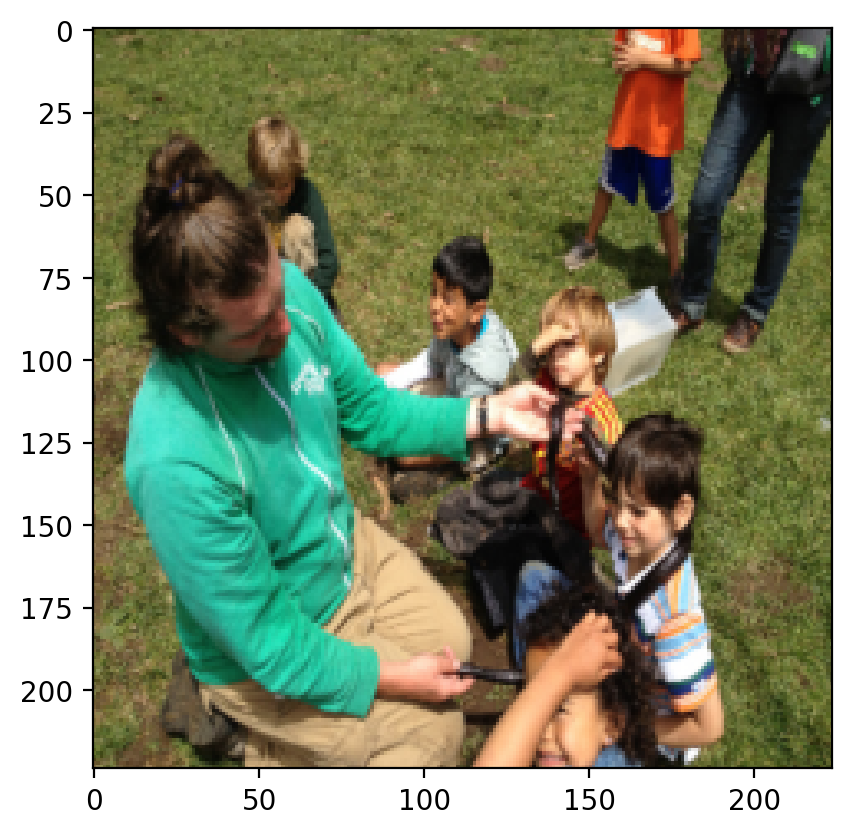

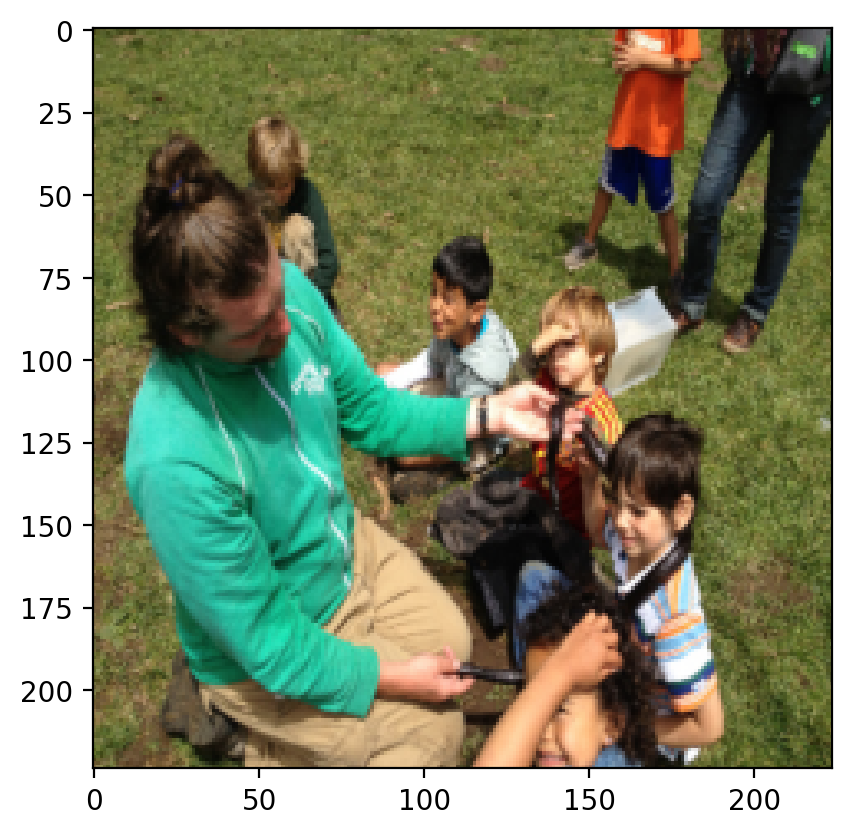

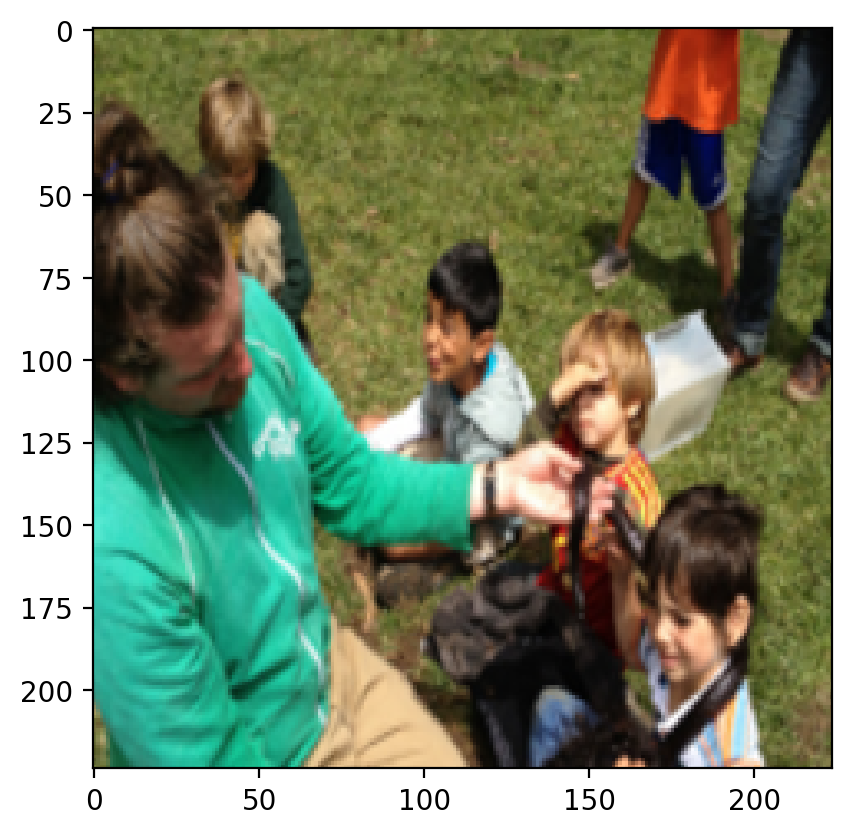

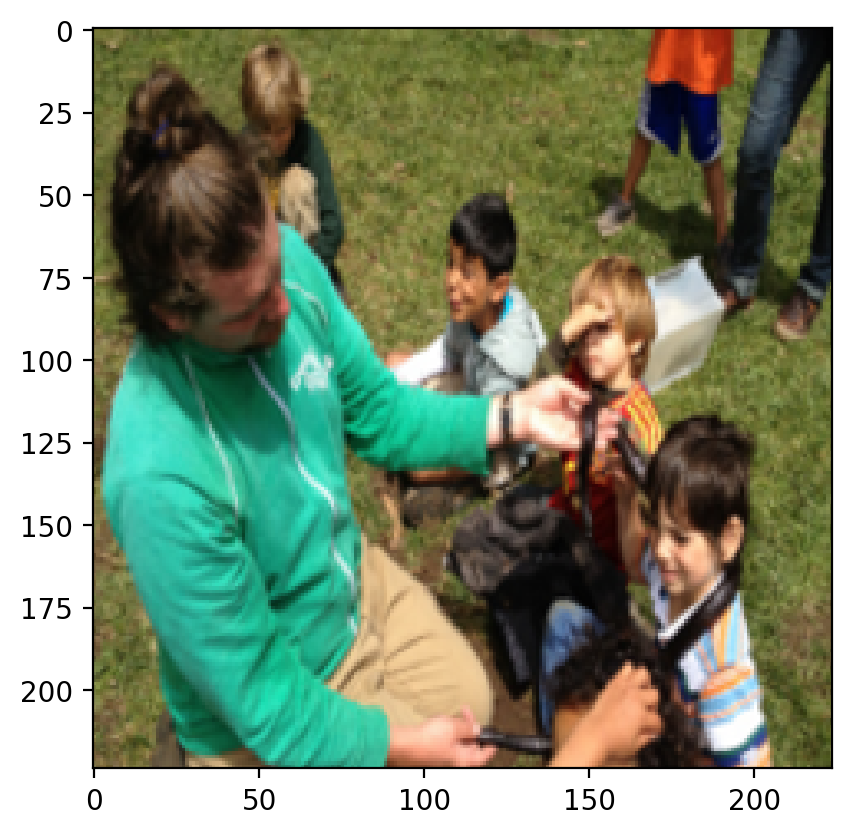

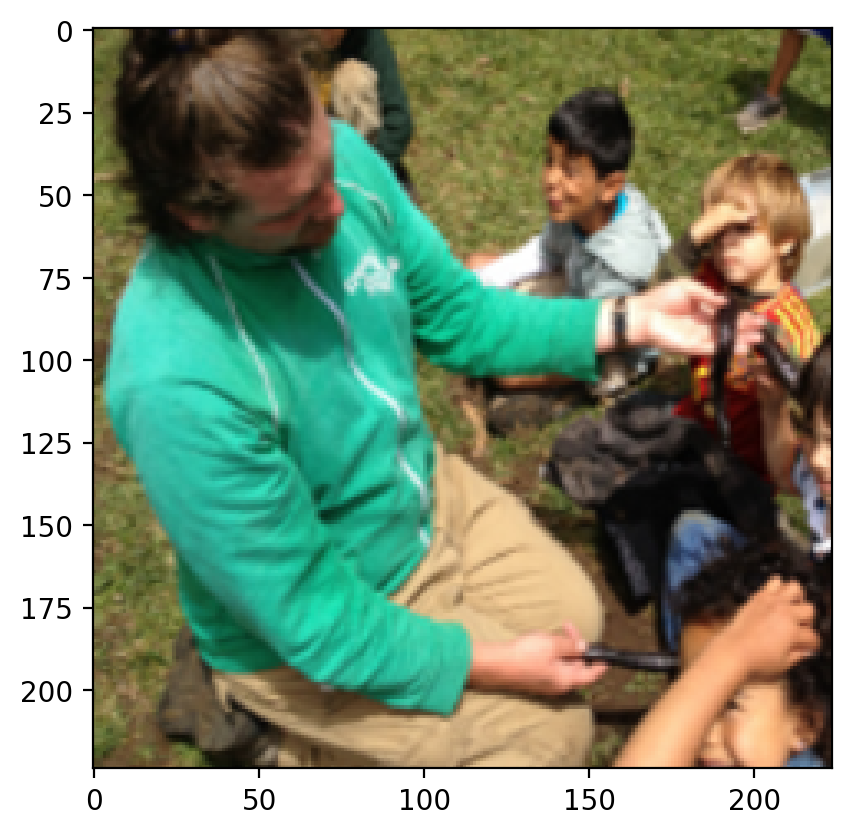

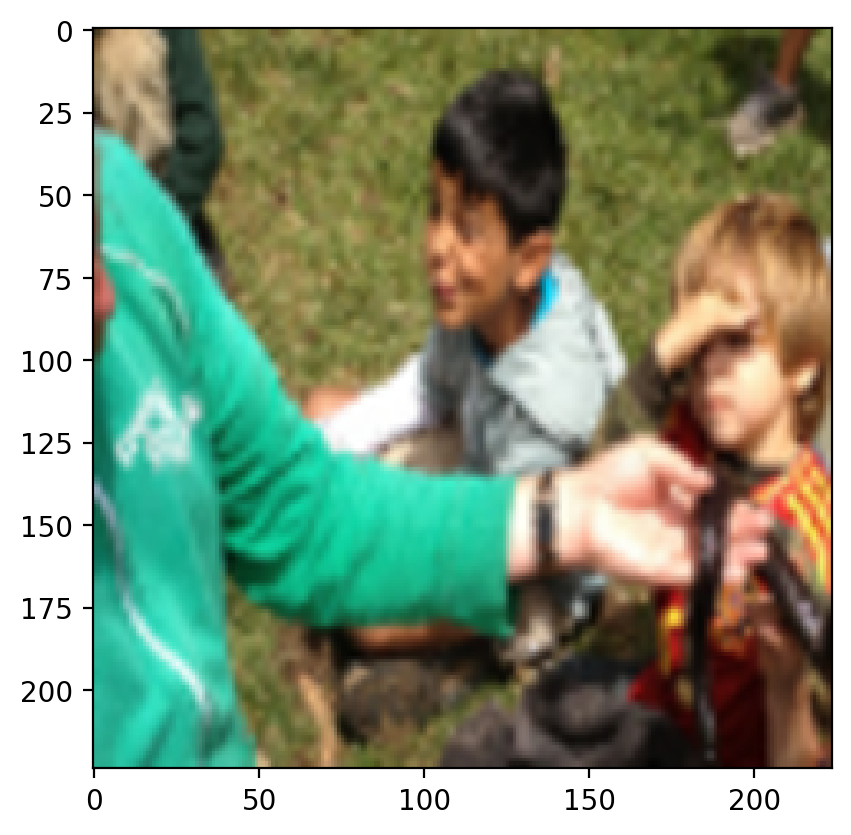

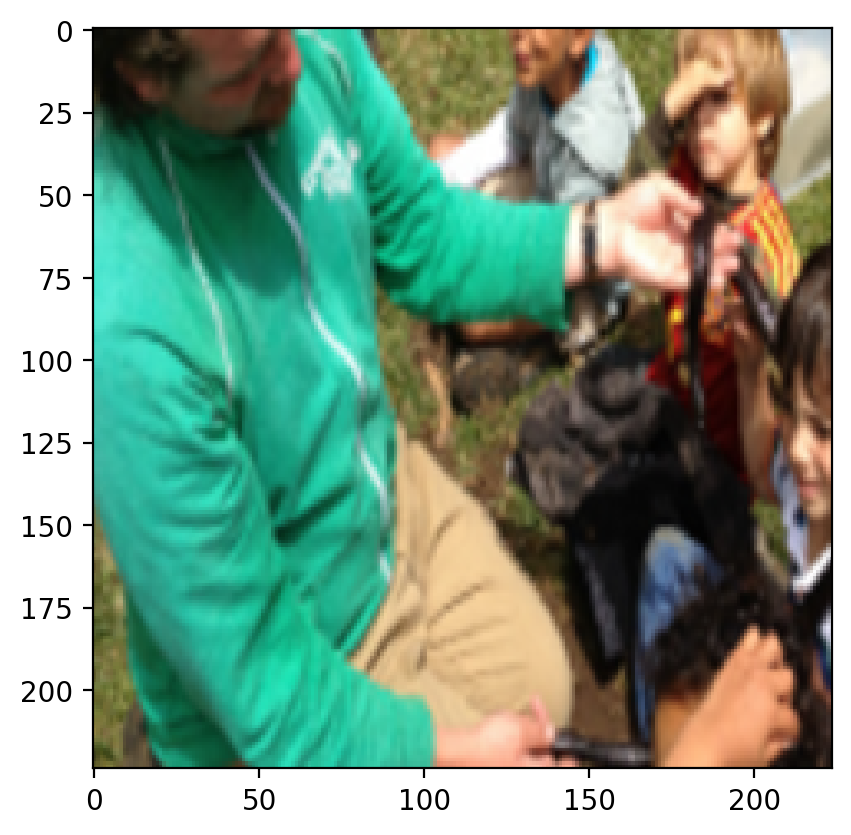

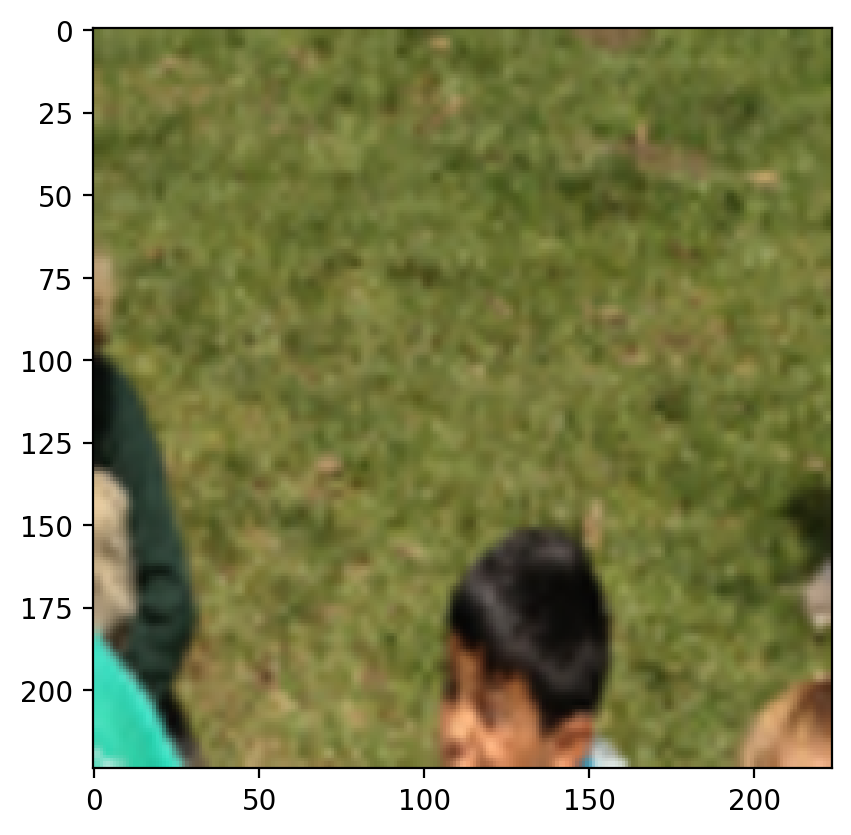

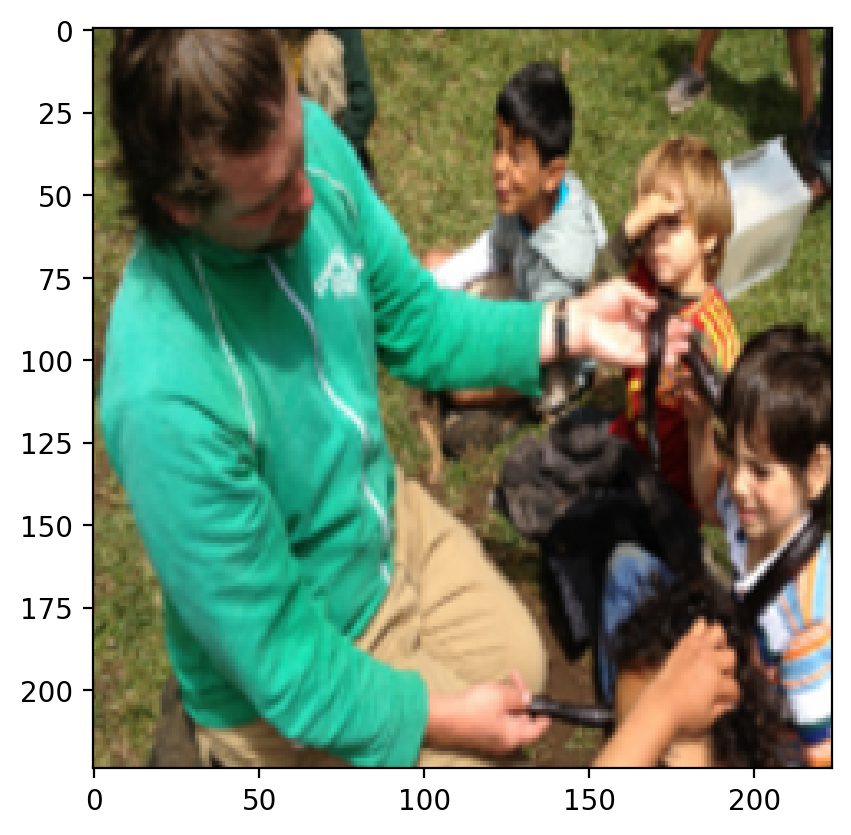

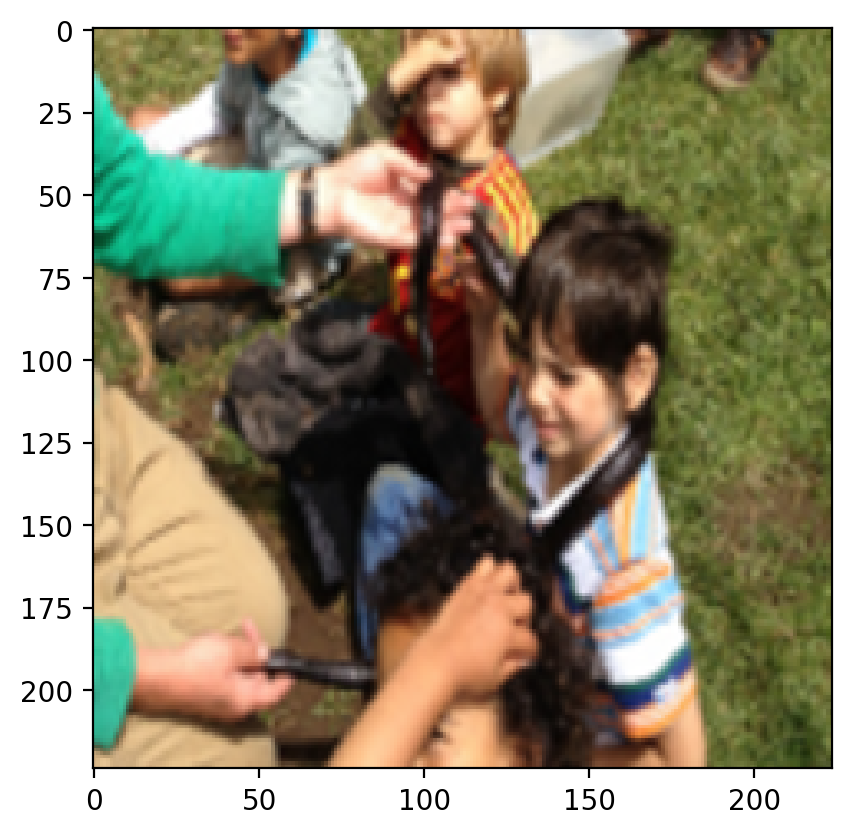

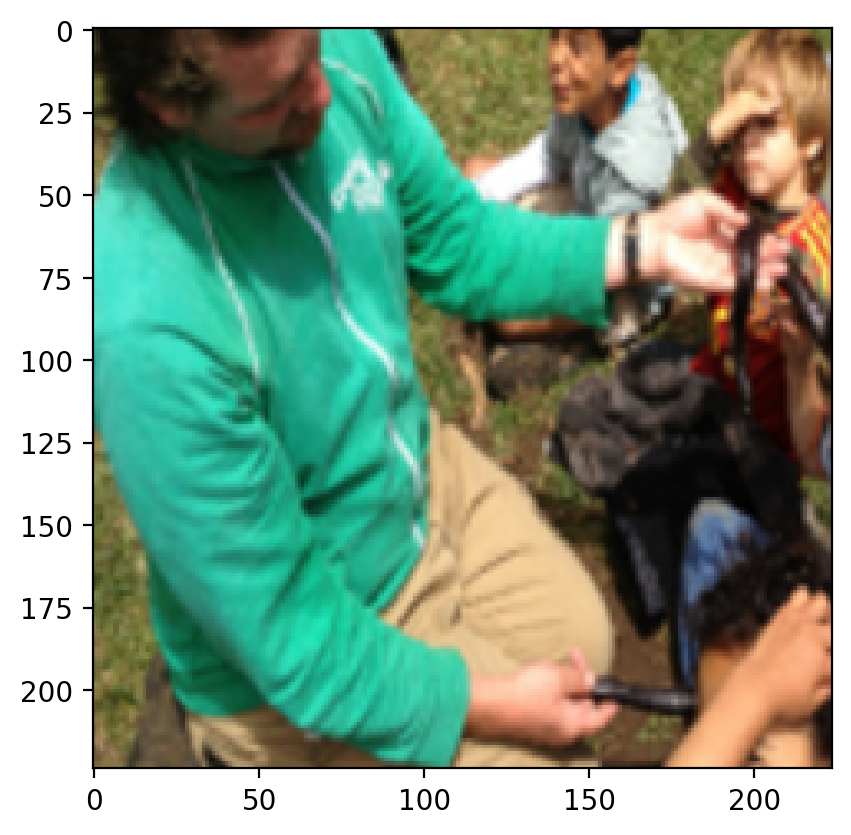

In [ ]:
img, img_class = next(iter(train_loader_imagenetv2))
img = img.squeeze()
#print(img.size())
plt.imshow(img.permute(1,2,0))
plt.show()
n_aug = 10
a = augmentation(img, n_aug)
#print(a.dtype)
#print(a.size())
for i in range(0, n_aug):
  plt.imshow((a[i]).permute(1, 2, 0))
  plt.show()

Custom Text Encoder

In [ ]:
from clip.simple_tokenizer import SimpleTokenizer as _Tokenizer

_tokenizer = _Tokenizer()

In [ ]:
class TextEncoder(nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        self.transformer = clip_model.transformer
        self.positional_embedding = clip_model.positional_embedding
        self.ln_final = clip_model.ln_final
        self.text_projection = clip_model.text_projection

    def forward(self, prompts, tokenized_prompts):
        x = prompts + self.positional_embedding
        x = x.permute(1, 0, 2)  # [batch_size, n_ctx, transformer.width] -> [n_ctx, batch_size, transformer.width]
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # [n_ctx, batch_size, transformer.width] -> [batch_size, n_ctx, transformer.width]
        x = self.ln_final(x)

        # Take features from the eot embedding (eot_token is the highest number in each sequence)
        x = x[torch.arange(x.shape[0]), tokenized_prompts.argmax(dim=-1)] @ self.text_projection

        return x

Prompt Learner, class that holds the learnable params

In [ ]:
class PromptLearner(nn.Module):
    def __init__(self, clip_model, classnames, n_ctx, ctx_init, class_token_position, csc=False):
        super().__init__()
        n_cls = len(classnames)
        ctx_dim = clip_model.ln_final.weight.shape[0]
        clip_imsize = clip_model.visual.input_resolution

        # Use given words to initialize context vectors
        if ctx_init:
            ctx_init = ctx_init.replace("_", " ")
            n_ctx = len(ctx_init.split(" "))
            prompt = clip.tokenize(ctx_init).to(clip_model.token_embedding.weight.device)
            with torch.no_grad():
                embedding = clip_model.token_embedding(prompt)
            ctx_vectors = embedding[0, 1 : 1 + n_ctx, :]
            prompt_prefix = ctx_init
        else:
            if csc:
                print("Initializing class-specific contexts")
                ctx_vectors = torch.empty(n_cls, n_ctx, ctx_dim)
            else:
                print("Initializing a generic context")
                ctx_vectors = torch.empty(n_ctx, ctx_dim)

            torch.nn.init.normal_(ctx_vectors, std=0.02)
            prompt_prefix = " ".join(["X"] * n_ctx)

        print(f"Initial context: '{prompt_prefix}'")
        print(f"Number of context words (tokens): {n_ctx}")

        # These are the `prompts` we want to optimize
        self.ctx = nn.Parameter(ctx_vectors)

        classnames = [name.replace("_", " ") for name in classnames]
        name_lens = [len(_tokenizer.encode(name)) for name in classnames]
        prompts = [prompt_prefix + " " + name + "." for name in classnames]

        # print("+++")
        # print("Prompts:")
        # for p in prompts:
        #     print(p)
        # print("+++")

        tokenized_prompts = torch.cat([clip.tokenize(p) for p in prompts]).to(clip_model.token_embedding.weight.device)

        with torch.no_grad():
            embedding = clip_model.token_embedding(tokenized_prompts)

        # These token vectors will be saved when in save_model(),
        # but they should be ignored in load_model() as we want to use
        # those computed using the current class names
        self.register_buffer("token_prefix", embedding[:, :1, :])  # SOS
        self.register_buffer("token_suffix", embedding[:, 1 + n_ctx :, :])  # CLS, EOS

        self.n_cls = n_cls
        self.n_ctx = n_ctx
        self.tokenized_prompts = tokenized_prompts
        self.name_lens = name_lens
        self.class_token_position = class_token_position

    def forward(self):
        prefix = self.token_prefix
        suffix = self.token_suffix
        ctx = self.ctx

        # If CoOp, expand the ctx for all classes
        if ctx.dim() == 2:
            ctx = ctx.unsqueeze(0).expand(self.n_cls, -1, -1)

        if self.class_token_position == "end":
            prompts = torch.cat(
                [
                    prefix,  # (n_cls, 1, dim)
                    ctx,     # (n_cls, n_ctx, dim)
                    suffix,  # (n_cls, *, dim)
                ],
                dim=1,
            )

        elif self.class_token_position == "middle":
            half_n_ctx = self.n_ctx // 2
            prompts = []
            for i in range(self.n_cls):
                name_len = self.name_lens[i]
                prefix_i = prefix[i : i + 1, :, :]
                class_i = suffix[i : i + 1, :name_len, :]
                suffix_i = suffix[i : i + 1, name_len:, :]
                ctx_i_half1 = ctx[i : i + 1, :half_n_ctx, :]
                ctx_i_half2 = ctx[i : i + 1, half_n_ctx:, :]
                prompt = torch.cat(
                    [
                        prefix_i,     # (1, 1, dim)
                        ctx_i_half1,  # (1, n_ctx//2, dim)
                        class_i,      # (1, name_len, dim)
                        ctx_i_half2,  # (1, n_ctx//2, dim)
                        suffix_i,     # (1, *, dim)
                    ],
                    dim=1,
                )
                prompts.append(prompt)
            prompts = torch.cat(prompts, dim=0)

        elif self.class_token_position == "front":
            prompts = []
            for i in range(self.n_cls):
                name_len = self.name_lens[i]
                prefix_i = prefix[i : i + 1, :, :]
                class_i = suffix[i : i + 1, :name_len, :]
                suffix_i = suffix[i : i + 1, name_len:, :]
                ctx_i = ctx[i : i + 1, :, :]
                prompt = torch.cat(
                    [
                        prefix_i,  # (1, 1, dim)
                        class_i,   # (1, name_len, dim)
                        ctx_i,     # (1, n_ctx, dim)
                        suffix_i,  # (1, *, dim)
                    ],
                    dim=1,
                )
                prompts.append(prompt)
            prompts = torch.cat(prompts, dim=0)

        else:
            raise ValueError

        return prompts

Custom CLIP model, CoOp

In [ ]:
class OurCLIP(nn.Module):
    def __init__(self, classnames, n_ctx, ctx_init, class_token_position, csc=False):
        super().__init__()
        clip_model, _ = clip.load("ViT-B/16") #ViT-B/16
        # clip_model = clip_model.cpu()
        clip_model = clip_model.float()

        self.prompt_learner = PromptLearner(clip_model, classnames, n_ctx, ctx_init, class_token_position, csc=csc)
        self.tokenized_prompts = self.prompt_learner.tokenized_prompts
        self.image_encoder = clip_model.visual
        self.text_encoder = TextEncoder(clip_model)
        self.logit_scale = clip_model.logit_scale

    def forward(self, image):
        image_features = self.image_encoder(image)

        prompts = self.prompt_learner()
        tokenized_prompts = self.tokenized_prompts
        text_features = self.text_encoder(prompts, tokenized_prompts)

        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        logit_scale = self.logit_scale.exp()
        #print("Our clip")
        #print(image_features.size())
        #print(text_features.size())
        logits = logit_scale * image_features @ text_features.t()
        #print(logits.size())
        return logits

Define the optimizer: we use AdamW as in the paper of TPT

In [ ]:
def get_optimizer(model, lr):
    optimizer = torch.optim.AdamW([
        {"params": model.parameters()}
    ], lr=lr)

    return optimizer

In [ ]:
def embed_dataset_classnames(list_of_labels):
    descriptions = [f"a photo of a {label}." for label in list_of_labels]
    #print(descriptions)
    if device == "cuda":
      text_tokens = clip.tokenize(descriptions).cuda()
    else:
      text_tokens = clip.tokenize(descriptions).cpu()

    # Get the normalized textual features
    with torch.no_grad():
        texts_z = model.encode_text(text_tokens).float()
        texts_z /= texts_z.norm(dim=-1, keepdim=True)

    return descriptions, texts_z

In [ ]:
embeddings, _ = embed_dataset_classnames(imageneta_classes)
print(embeddings)

['a photo of a stingray.', 'a photo of a goldfinch.', 'a photo of a junco.', 'a photo of a American robin.', 'a photo of a jay.', 'a photo of a bald eagle.', 'a photo of a vulture.', 'a photo of a newt.', 'a photo of a American bullfrog.', 'a photo of a box turtle.', 'a photo of a green iguana.', 'a photo of a agama.', 'a photo of a chameleon.', 'a photo of a American alligator.', 'a photo of a garter snake.', 'a photo of a harvestman.', 'a photo of a scorpion.', 'a photo of a tarantula.', 'a photo of a centipede.', 'a photo of a sulphur-crested cockatoo.', 'a photo of a lorikeet.', 'a photo of a hummingbird.', 'a photo of a toucan.', 'a photo of a duck.', 'a photo of a goose.', 'a photo of a koala.', 'a photo of a jellyfish.', 'a photo of a sea anemone.', 'a photo of a flatworm.', 'a photo of a snail.', 'a photo of a crayfish.', 'a photo of a hermit crab.', 'a photo of a flamingo.', 'a photo of a great egret.', 'a photo of a oystercatcher.', 'a photo of a pelican.', 'a photo of a sea 

Define the method for confident selection

In [ ]:
def select_confident_samples(logits, top):
  #print("Logits size:")
  #print(logits.size())
  #with torch.no_grad(): ##############################
  batch_entropy = -(logits.softmax(1) * logits.log_softmax(1)).sum(1)
  #print("size of batch_entropy: ")
  #print(batch_entropy)
  idx = torch.argsort(batch_entropy, descending=False)[:int(batch_entropy.size()[0] * top)]
  return logits[idx], idx

Define the average entropy




In [ ]:
def avg_entropy(outputs):
  logits = outputs.log_softmax(dim=1) #[N, 1000]
  avg_logits = logits.mean(0) #[1, 1000]
  min_real = torch.finfo(avg_logits.dtype).min
  avg_logits = torch.clamp(avg_logits, min=min_real)
  return -(avg_logits * torch.exp(avg_logits)).sum(dim=-1)

2 prototypes for Average Entropy computation

In [ ]:
def avg_entropy2(outputs):
  logits = outputs - outputs.logsumexp(dim=-1, keepdim=True) #
  #logits = outputs.log_softmax(dim=1) #[N, 1000]
  avg_logits = logits.logsumexp(dim=0) - np.log(logits.shape[0]) #
  #avg_logits = logits.mean(0) #[1, 1000]
  min_real = torch.finfo(avg_logits.dtype).min
  avg_logits = torch.clamp(avg_logits, min=min_real)
  return -(avg_logits * torch.exp(avg_logits)).sum(dim=-1)

In [ ]:
def avg_entropy3(outputs): # custom
  logits = outputs.softmax(1) #[1, 1000]
  avg_logits = logits.mean(0)
  #print(avg_logits.size())
  return -(avg_logits.softmax(0) * avg_logits.log_softmax(0)).sum(0)

In [ ]:
def test_time_tuning_step_(net, data_loader, optimizer, steps=2, device="cuda:0", top = 0.1, n_aug = 64):
    # we expect to have a batch of 1 single image at time

    #samples = 0.0
    #cumulative_accuracy = 0.0

    torch.save(net.state_dict(), 'init_network.pt') # save initial state dict

    j = 0
    max_tests = 50
    good_pred = 0
    # Iterate over the data set
    for batch_idx, (inputs, targets) in enumerate(data_loader):
        if j >= max_tests: # test up to max_tests samples
          break

        net.load_state_dict(torch.load('init_network.pt')) # load the initial state of the network for each test

        # Load data into GPU
        inputs = inputs.to(device)
        targets = targets.to(device)

        # evaluation mode
        net.eval()
        #print(inputs.size())
        #print(targets)
        # output the pre training prediction of input
        pre_pred = net(inputs)
        pre_pred = (pre_pred.max(dim=1))[1]


        # Augmentation
        inputs_aug = augmentation(inputs, n_aug).to(device)
        #print(f"Size of the tensor of aug images: {inputs_aug.size()}")
        print(f"Test n. {j}")

        # training mode
        net.train()

        for i in range(steps): # iterate through steps
          #print(f"Step {i}")

          # Forward pass:
          # -) Pass to image encoder
          outputs = net(inputs_aug)
          # -) Confidence Selection
          outputs, _ = select_confident_samples(outputs, top)
          #print("Output")
          #print(outputs[0,:])
          #print("Size of selected samples")
          #print(outputs.size())
          #print("entropies avg")
          #print(avg_entropy(outputs))
          #print(avg_entropy2(outputs))
          #print(avg_entropy3(outputs))

          # -) Loss computation
          loss = avg_entropy(outputs)

          # Backward pass
          loss.backward()

          # Parameters update
          optimizer.step()

          # Gradients reset
          optimizer.zero_grad()

        # evaluation mode
        net.eval()
        pred = net(inputs)
        #print("Predicted size: ")
        #print(pred.size()) [1, n_classes]
        #print("Normalized distribution of prediction?")
        #print(pred.sum(1))
        #print("Ground truth and prediction: ")
        ##################################
        #print("prediction size")
        #print(pred.size())
        #print(pred)
        pred = (pred.max(dim=1))[1] # take most probable label
        #print(targets, pred)
        #####################################
        print(f"Real label: {imageneta_classes[targets.item()]}")
        print(f"Pre trained Predicted label: {imageneta_classes[pre_pred.item()]}")
        print(f"Predicted label: {imageneta_classes[pred.item()]}")
        # plot image
        #inputs_c = inputs.cpu()
        #inputs_c = inputs_c.squeeze()
        #plt.imshow(inputs_c.permute(1,2,0))
        #plt.show()

        j += 1
        if (imageneta_classes[targets.item()] == imageneta_classes[pred.item()]):
          print("Good prediction")
          good_pred +=1
        # delete variables (clean up memory)
        del inputs
        del inputs_aug
        del targets
        torch.cuda.empty_cache()
    print(f"Good predictions: {good_pred} out of 100 tests")



In [ ]:
def main_tpt(
    classes=imageneta_classes,
    device="cuda:0",
    learning_rate=0.005,
    steps=2,
    run_name="exp1",
    n_ctx=4,
    ctx_init="",
    class_token_position="end",
    csc=False,
    data_loader = test_loader_imageneta
):
    # Create a logger for the experiment
    # writer = SummaryWriter(log_dir=f"runs/{run_name}")

    # Get classnames encoded
    classnames, _ = embed_dataset_classnames(classes) # shitty way to encode classes: todo for imagenetV2

    # Instantiate the network and move it to the chosen device (GPU)
    net = OurCLIP(
        classnames=classnames, n_ctx=n_ctx, ctx_init=ctx_init, class_token_position=class_token_position, csc=csc
    ).to(device)

    print("Turning off gradients in both the image and the text encoder")
    for name, param in net.named_parameters():
        if "prompt_learner" not in name:
            param.requires_grad_(False)

    print(f"Total parameters: {sum(p.numel() for p in net.parameters()):,}")
    print(f"Total trainable parameters: {sum(p.numel() for p in net.parameters() if p.requires_grad):,}")
    print("")

    # Instantiate the optimizer
    optimizer = get_optimizer(net, learning_rate)

    test_time_tuning_step_(net, data_loader, optimizer, steps=steps, device=device, top = 0.1, n_aug = 64)

In [ ]:
main_tpt(device = device)

Initializing a generic context
Initial context: 'X X X X'
Number of context words (tokens): 4
Turning off gradients in both the image and the text encoder
Total parameters: 124,325,889
Total trainable parameters: 2,048

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Good predictions: 28 out of 100 tests
